# GMM Classifier

In this notebook, I'm going to implement a Gaussian Naive Bayes model and a Gaussian Mixture Model on a handwritten digits dataset.

**Key words:** PCA, GNB, GMM (AIC, BIC).

## Import

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.mixture import GaussianMixture

print("Import successfully!")

Import successfully!


## Dataset

I'll use the handwritten dataset in the sklearn package.

In [ ]:
digits = load_digits()

print(f"Shape of digits.images: {digits.images.shape}")

Shape of digits.images: (1797, 8, 8)


Take a glance of 10 images.

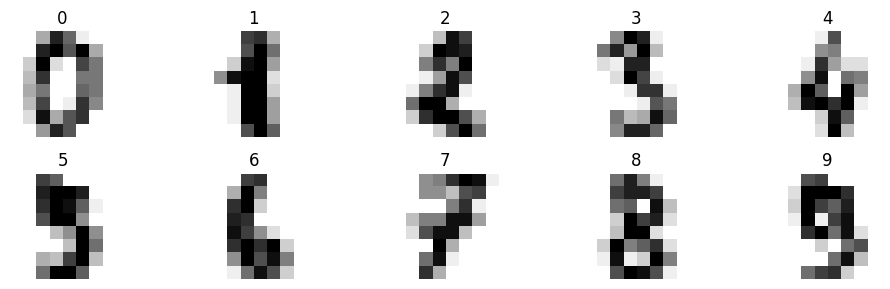

In [ ]:
# Display 10 images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 3))
for ax, image, label in zip(axes.flat, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title(label)
plt.tight_layout()
plt.show()

## Preprocessing

The original data has $8 \times 8 = 64$ features. I'll use PCA to do dimensionality reduction to preserve 95% of the total variance.

In [ ]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=936)

print("Split successfully!")

Split successfully!


In [ ]:
# PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Data shape after PCA:{X_train_pca.shape}")

Data shape after PCA:(1437, 28)


After dimensionality reduction, data only has 28 features. It'll reduce the computational cost.

## Gaussian Naive Bayes

Build a Gaussian Naive Bayes model as baseline.

### Model Training

Time the training (For the purpose of comparison)

In [ ]:
# Train the GNB model
gnb = GaussianNB()

# Time the training
start_time = time.time()
gnb.fit(X_train_pca, y_train)
end_time = time.time()
time_gnb = end_time - start_time

print(f"GNB trained successfully! It took {time_gnb:.4f} seconds.")

GNB trained successfully! It took 0.0087 seconds.


### Model Evaluation

GNB Accuracy: 0.9250


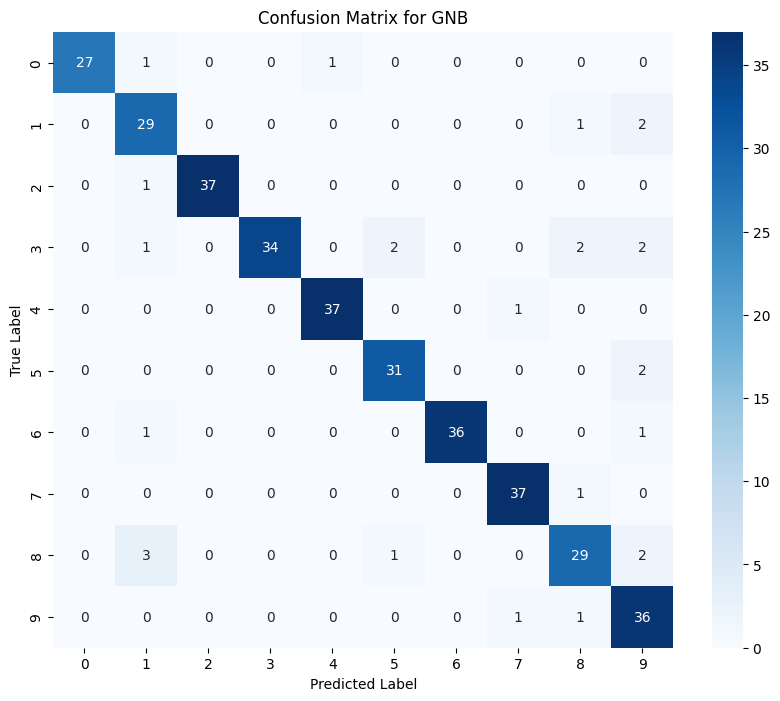

In [ ]:
# Evaluate the model
y_pred_gnb = gnb.predict(X_test_pca)

# Calculate the accuracy
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)
print(f"GNB Accuracy: {accuracy_gnb:.4f}")

# Calculate the confusion matrix
cm_gnb = confusion_matrix(y_test, y_pred_gnb)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_gnb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for GNB')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Gaussian Mixture Model

Train a GMM for each class.

### Model Training

In [ ]:
# Build the model class
class GMMClassifier:
    def __init__(self, k=3, random_state=936):
        self.k = k
        self.random_state = random_state
        self.gmms = {}
        self.classes_labels = None

    def fit(self, X, y):
        self.classes_labels = np.unique(y)
        for label in self.classes_labels: # For each class, fit a GMM
            X_current = X[y == label]
            gmm = GaussianMixture(n_components=self.k, random_state=self.random_state)
            gmm.fit(X_current)
            self.gmms[label] = gmm

    def predict_proba(self, X):
        probabilities = []
        for label in self.classes_labels:
            gmm = self.gmms[label]
            probabilities.append(gmm.score_samples(X))
        probabilities = np.array(probabilities) # Shape: (number of classes, number of data)
        probabilities = probabilities.T # Shape: (number of data, number of classes)
        probabilities = np.exp(probabilities)
        sum_probabilities = probabilities.sum(axis=1, keepdims=True) # Shape: (number of data, 1)
        probabilities = probabilities / (sum_probabilities + 1e-10)

        return probabilities

    def predict(self, X):
        probabilities = self.predict_proba(X)
        predicted_indices = np.argmax(probabilities, axis=1)

        return self.classes_labels[predicted_indices]

    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

print("GMM defined successfully!")

GMM defined successfully!


### Tune Hyper-parameters

Tune the number of components (k) in GMM model by checking AIC and BIC.

In [ ]:
# Tune from 1 to 10
n_components_range = np.arange(1, 11)
accuracy_scores = []
aic_scores = []
bic_scores = []

for comp in n_components_range:
    gmm_temp = GMMClassifier(k=comp)
    gmm_temp.fit(X_train_pca, y_train)

    current_aic = 0
    current_bic = 0
    for label in gmm_temp.classes_labels:
        gmm_t = gmm_temp.gmms[label]
        X_current_train = X_train_pca[y_train == label]
        current_aic += gmm_t.aic(X_current_train)
        current_bic += gmm_t.bic(X_current_train)

    aic_scores.append(current_aic)
    bic_scores.append(current_bic)

    # Calculate accuracy
    accuracy = gmm_temp.score(X_test_pca, y_test)
    accuracy_scores.append(accuracy)

print(f"Tune successfully! n_components_range: {n_components_range}")

Tune successfully! n_components_range: [ 1  2  3  4  5  6  7  8  9 10]


Plot three scores.

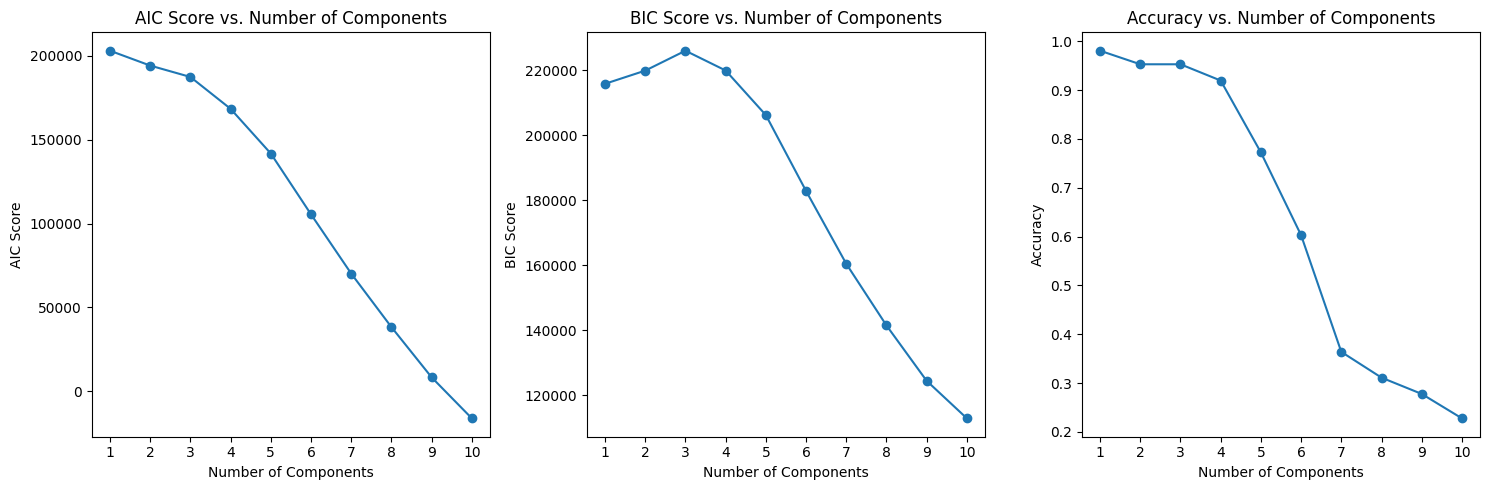

In [ ]:
plt.figure(figsize=(15, 5))

# Plot AIC scores
plt.subplot(1, 3, 1)
plt.plot(n_components_range, aic_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('AIC Score')
plt.title('AIC Score vs. Number of Components')
plt.xticks(n_components_range)

# Plot BIC scores
plt.subplot(1, 3, 2)
plt.plot(n_components_range, bic_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('BIC Score vs. Number of Components')
plt.xticks(n_components_range)

# Plot Accuracy scores
plt.subplot(1, 3, 3)
plt.plot(n_components_range, accuracy_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Components')
plt.xticks(n_components_range)

plt.tight_layout()
plt.show()

We can see from the plots, although the AIC and BIC (lower is better) droped dramaticly, the GMM model overfitted really fast as the number of components increased. Because I used training data for AIC and BIC, those two scores kept dropping as the model overfitted. The accuracy is the highest when the number of components is 1.

### Model Evaluation

Use number of components (K) is 1.

GMM trained successfully! It took 0.2092 seconds.
GMM accuracy is 0.9806


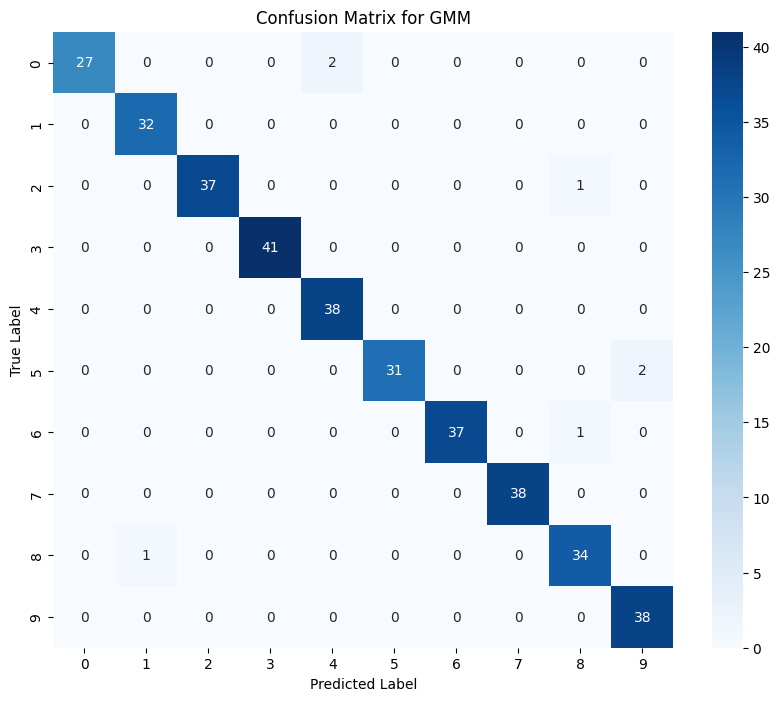

In [ ]:
# Train the model
gmm_best = GMMClassifier(k=1)

start_time = time.time()
gmm_best.fit(X_train_pca, y_train)
end_time = time.time()
time_gmm = end_time - start_time

print(f"GMM trained successfully! It took {time_gmm:.4f} seconds.")

# Evaluate the model
print(f"GMM accuracy is {gmm_best.score(X_test_pca, y_test):.4f}")

# Calculate the confusion matrix
y_pred_gmm = gmm_best.predict(X_test_pca)
cm_gmm = confusion_matrix(y_test, y_pred_gmm)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_gmm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for GMM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Comparision

- Gaussian Naive Bayes
  - Accuracy: 0.9250
  - Time: 0.0087
- Gaussian Mixture Model
  - Accuracy: 0.9806
  - Time: 0.2092

---

- GNB = fast, simple, assumes each class is a single Gaussian with independent features.
- GMM = flexible, allows multiple Gaussian components per class (multi-modal, correlated features), but needs EM and careful tuning, takes more time.